In [2]:
from typing import Dict, Iterable, Tuple, List
import numpy as np
import pandas as pd

def split_indices_by_chrom(indices,res='1kb',ratios=(0.70, 0.15, 0.15),seed=42):
    """
    Split the given indices into train/val/test with the requested ratios,
    performed independently within each chromosome range, then concatenated.

    Parameters
    ----------
    indices : iterable of int or pd.Index
        The indices you want to split.
    res : str
        1kb or 5kb
    ratios : tuple
        (train, val, test) ratios; must sum to 1.0 (within float tolerance).
    seed : int
        RNG seed for reproducibility.

    Returns
    -------
    dict
        {"train": pd.Index, "val": pd.Index, "test": pd.Index}
    """
    if res == '1kb':
        chrom_ranges = {
            "chr2L": (0,      23513),
            "chr2R": (23514,  48800),
            "chr3L": (48801,  76911),
            "chr3R": (76912,  108991),
            "chr4":  (108992, 110340),
            "chrX":  (110341, 133883),
            "chrY":  (133884, 137551),
        }
    else:
        # 5kb
        chrom_ranges = {
            "chr2L": (0,      23513),
            "chr2R": (23514,  48800),
            "chr3L": (48801,  76911),
            "chr3R": (76912,  108991),
            "chr4":  (108992, 110340),
            "chrX":  (110341, 133883),
            "chrY":  (133884, 137551),
        }

    train_all: List[int] = []
    val_all:   List[int] = []
    test_all:  List[int] = []

    rng = np.random.default_rng(seed)

    # Ensure indices are unique integers
    indices = pd.Index(indices).astype(int).unique().sort_values()

    for chrom, (start, end) in chrom_ranges.items():
        # Inclusive range filter
        mask = (indices >= start) & (indices <= end)
        chrom_idx = indices[mask].to_numpy()
        if chrom_idx.size == 0:
            continue

        # Shuffle within chromosome
        rng.shuffle(chrom_idx)

        n = chrom_idx.size
        n_train = int(np.floor(n * ratios[0]))
        n_val   = int(np.floor(n * ratios[1]))
        n_test  = n - n_train - n_val  # ensure total matches

        train_all.extend(chrom_idx[:n_train])
        val_all.extend(chrom_idx[n_train:n_train + n_val])
        test_all.extend(chrom_idx[n_train + n_val:])

    return {
        "train": pd.Index(sorted(train_all), dtype="int64"),
        "val":   pd.Index(sorted(val_all),   dtype="int64"),
        "test":  pd.Index(sorted(test_all),  dtype="int64"),
    }


In [10]:
import pandas as pd
import numpy as np
import torch 

# target variable
target_variable = pd.read_table('/users/jaguile1/data/shared_data/BindGPS/data/mE_RNAseq_RPKMnorm.1kb_binned.tsv')
target_variable = target_variable[target_variable['chr'] != 'chrM'].reset_index(drop=True)
y = target_variable['counts'].replace(np.nan,0)

# train, val, test mask; stratified per chromosome
all_mask = target_variable['gene_in_bin']
true_mask_idx = all_mask[all_mask].index

splits = split_indices_by_chrom(true_mask_idx,'1kb',ratios=(0.70, 0.15, 0.15), seed=42) # splitting by chrom, see cell above
train_idx,val_idx,test_idx = splits["train"],splits["val"],splits["test"]

train_mask = np.full(all_mask.shape[0],False)
train_mask[train_idx] = True

val_mask = np.full(all_mask.shape[0],False)
val_mask[val_idx] = True

test_mask = np.full(all_mask.shape[0],False)
test_mask[test_idx] = True

# node features
node_features = pd.read_table('/users/jaguile1/data/shared_data/BindGPS/data/data_transformation/chipseq/updated_histone_mods_and_GA_factors.feature_matrix.1kb_res.reindexed.txt')
X = node_features.loc[:,'clamp':'psq']

# edges
sig_interactions = pd.read_table('/users/jaguile1/data/shared_data/BindGPS/data/S2_gfp_RNAi_significant_interactions_v2/S2_gfpi_loops.1kb_res.p0_1.v2.bedpe')
edges = sig_interactions.loc[:,'bin1':'bin2']

# edge weights
edge_weight = -1 * np.log10(sig_interactions['p-value'] + 1e-300)
max = np.percentile(edge_weight,q=99.99)
edge_weight = np.minimum(edge_weight,max)
sig_interactions['p-value_transformed'] = edge_weight
# print(np.sum(edge_weights >= max)) # print number of capped edge_weights; 870 at 1kb

# to torch
X = torch.tensor(X.to_numpy())
y = torch.tensor(y.to_numpy())
all_mask= torch.tensor(all_mask.to_numpy())
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(val_mask)
test_mask = torch.tensor(test_mask)
edge_index = torch.tensor(edges.transpose().to_numpy())
edge_weight = torch.tensor(edge_weight.transpose().to_numpy())

# out
print("Node features:\t",X.shape)
print("All Mask:\t",all_mask.shape)
print("Train Mask:\t",train_mask.shape)
print("Val Mask:\t",train_mask.shape)
print("Test Mask:\t",train_mask.shape)
print("Target Variable:",y.shape)
print("Edge weights:\t",edge_weight.shape)
print("Edge indices:\t",edges.shape)

Node features:	 torch.Size([137552, 11])
All Mask:	 torch.Size([137552])
Train Mask:	 torch.Size([137552])
Val Mask:	 torch.Size([137552])
Test Mask:	 torch.Size([137552])
Target Variable: torch.Size([137552])
Edge weights:	 torch.Size([8696505])
Edge indices:	 (8696505, 2)


In [19]:
edge_index

tensor([[     5,      5,      5,  ..., 134008, 134840, 136272],
        [     7,     10,     11,  ..., 134087, 134841, 136381]])

In [21]:
df = node_features.loc[:,'clamp':'psq'].copy()

In [26]:
df.describe()

,clamp,gaf,h3k27ac,h3k27me3,h3k36me3,h3k4me1,h3k4me2,h3k4me3,h3k9me3,h4k16ac,psq
count,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000,137552.000000
mean,9.154767,8.956710,116.441571,293.411273,219.892453,216.080304,69.878465,223.555342,11.996100,62.237432,90.430799
std,18.904170,23.589594,107.541041,295.848324,395.765234,193.852226,211.752761,475.845230,25.511971,181.490036,1103.425840
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.072608,0.059193,60.027500,40.001980,20.082353,110.065347,0.000000,60.009901,1.000000,0.000000,50.012250
50%,10.013434,0.099541,100.065000,260.022772,60.015525,160.097030,0.000000,100.001980,10.014286,0.000000,80.028082
75%,10.049630,10.038025,150.002439,470.083168,230.042301,260.087129,0.000000,150.052475,10.042857,0.000000,110.072860
max,2790.058926,1390.073380,3510.060976,2340.063366,6660.016188,2800.088119,8660.085000,4640.026733,570.045018,4550.055000,405200.034112


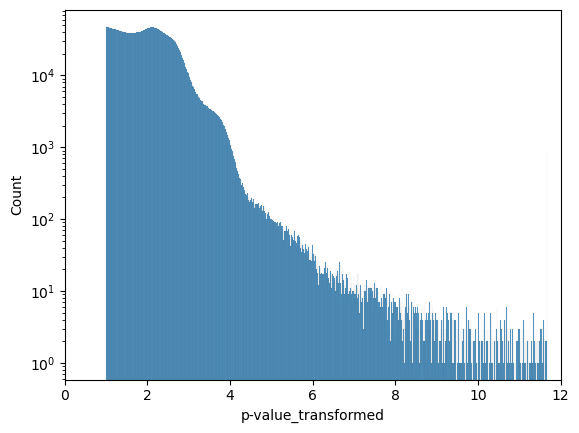

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(
    data=sig_interactions,
    x='p-value_transformed'
)
plt.semilogy(base=10)
plt.xlim(0,12)
plt.show()

In [6]:
sig_interactions.head()

,chr1,start1,end1,chr2,start2,end2,contactCount,p-value,q-value,bias1,bias2,ExpCC,loop_size,bin1,bin2
0,chr2L,5000,6000,chr2L,7000,8000,18,0.002678,1.0,0.53777,1.078947,8.405956,1.0,5,7
1,chr2L,5000,6000,chr2L,10000,11000,9,0.016107,1.0,0.53777,1.102884,3.805077,4.0,5,10
2,chr2L,5000,6000,chr2L,11000,12000,9,0.008943,1.0,0.53777,1.206252,3.442715,5.0,5,11
3,chr2L,5000,6000,chr2L,12000,13000,10,0.001319,1.0,0.53777,1.266245,3.074528,6.0,5,12
4,chr2L,5000,6000,chr2L,13000,14000,6,0.049908,1.0,0.53777,1.233275,2.611784,7.0,5,13


In [ ]:
from torch_geometric.data import Data

data = Data(
    x=X,
    train_mask=train_mask,
    all_mask=all_mask,
    val_mask=val_mask,
    test_mask=test_mask,
    edge_index=edge_index,
    edge_weight=edge_weight,
    y=y
)

In [ ]:
data

In [ ]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data,
    num_neighbors=[30, 30],
    batch_size=32,          
    weight_attr='edge_weight',
)

In [ ]:
import torch

# Save
torch.save(data, "dataset.pt")

# Load
# data = torch.load("dataset.pt")